In [1]:
import sys
sys.path.append('..')
from MPRA_exp.utils import *
from MPRA_exp.metrics import *
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(x):
    return np.log(x/(1-x))

def find_indice_precise(info_df, cell_types=[], assays=[], IDs=[]):
    # 初始化索引为全部行
    indice = list(range(len(info_df)))
    
    # 如果 cell_types 不为空，则筛选 cell_type
    if cell_types:
        indice = [i for i in indice if info_df.iloc[i]['cell_type'] in cell_types]
        
    # 如果 assays 不为空，则筛选 assay
    if assays:
        indice = [i for i in indice if info_df.iloc[i]['assay'] in assays]
        
    # 如果 IDs 不为空，则筛选 ID
    if IDs:
        indice = [i for i in indice if info_df.iloc[i]['ID'] in IDs]
    
    return indice


def plot(main_df, cell_type, assay):
    x = main_df[f'{cell_type}_{assay}_pred']
    y = main_df[cell_type]
    r = pearsonr(x, y)[0]
    print(f'pearson r = {r:.3f}')

    fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    ax.set_position([left, bottom, right - left, top - bottom])
    sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    ax.set_xlabel(f'{cell_type}_{assay}_pred')
    ax.set_ylabel(f'{cell_type}_MPRA_true')
    ax.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=ax.transAxes, fontsize=16)
    plt.savefig(f'figures/{cell_type}_{assay}_pred.png', dpi=200)


def plot_logit(main_df, cell_type, assay):
    x = logit(main_df[f'{cell_type}_{assay}_pred'])
    y = main_df[cell_type]
    r = pearsonr(x, y)[0]
    print(f'pearson r = {r:.3f}')

    plot_scatter(x, y, 
                 xlabel=f'{cell_type}_{assay}_pred_logit', 
                 ylabel=f'{cell_type}_MPRA_true', 
                 text=f'pearson r = {r:.3f}', 
                 title=f'', 
                 filename=f'{cell_type}_{assay}_pred_logit')

    # fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    # left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    # ax.set_position([left, bottom, right - left, top - bottom])
    # sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    # ax.set_xlabel(f'{cell_type}_{assay}_pred_logit')
    # ax.set_ylabel(f'{cell_type}_MPRA_true')
    # ax.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=ax.transAxes, fontsize=16)
    # plt.savefig(f'figures/{cell_type}_{assay}_pred_logit.png', dpi=200)

    # plt.figure(figsize=(8, 6), dpi=50)
    # sns.scatterplot(x=x, y=y, s=1, edgecolor=None)
    # plt.xlabel(f'{cell_type}_{assay}_pred_logit')
    # plt.ylabel(f'{cell_type}_MPRA_true')
    # plt.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=plt.gca().transAxes, fontsize=16)
    # plt.savefig(f'figures/{cell_type}_{assay}_pred_logit.png', dpi=300, bbox_inches='tight')


def plot_scatter(x, y, xlabel='', ylabel='', text='', title='', filename=''):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    ax.set_position([left, bottom, right - left, top - bottom])
    sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(x=0.1, y=0.9, s=text, transform=ax.transAxes, fontsize=16)
    plt.title(title)
    plt.savefig(f'figures/{filename}.png', dpi=200)


def plot_logit_diff(main_df, cell_type1, cell_type2, assay):
    x = logit(main_df[f'{cell_type1}_{assay}_pred']) - logit(main_df[f'{cell_type2}_{assay}_pred'])
    y = main_df[cell_type1] - main_df[cell_type2]

    r = pearsonr(x, y)[0]
    print(f'pearson r = {r:.3f}')

    fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    ax.set_position([left, bottom, right - left, top - bottom])
    sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    ax.set_xlabel(f'{cell_type1}_{cell_type2}_{assay}_pred_logit_diff')
    ax.set_ylabel(f'{cell_type1}_{cell_type2}_MPRA_true_diff')
    ax.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=ax.transAxes, fontsize=16)
    plt.savefig(f'figures/{cell_type1}_{cell_type2}_{assay}_pred_logit_diff.png', dpi=200)



def pearson(x, y, allow_nan=True):
    if len(x) == 0 or len(y) == 0:
        return np.nan
    
    x_mask = ~np.isnan(x)
    y_mask = ~np.isnan(y)
    mask = x_mask & y_mask
    x = x[mask]
    y = y[mask]

    if len(x) == 0 or len(y) == 0:
        return np.nan
    if len(x) / len(mask) < 0.1:
        print(f'{mask.sum()} (less than 10%) values are non-nan.')

    r, _ = pearsonr(x, y)
    return r


def spearman(x, y, allow_nan=True):
    if len(x) == 0 or len(y) == 0:
        return np.nan
    
    x_mask = ~np.isnan(x)
    y_mask = ~np.isnan(y)
    mask = x_mask & y_mask
    x = x[mask]
    y = y[mask]

    if len(x) == 0 or len(y) == 0:
        return np.nan
    if len(x) / len(mask) < 0.1:
        print(f'less than 10% values are non-nan.')
    
    r, _ = spearmanr(x, y)
    return r

In [3]:
# def load_npy(filename):
#     data = []
#     with open(filename, 'rb') as f:
#         while True:
#             try:
#                 data.append(np.load(f))
#             except EOFError:
#                 break
#     data = np.concatenate(data, axis=0)
#     return data

# a = load_npy('../pretrained_models/Beluga/Beluga_Siraj_pred_2.npy')

In [4]:
lines = load_txt('../pretrained_models/Beluga/predictor_names.txt')
data = [line.rsplit('_', 2) for line in lines]
# print(data)
for i in range(len(data)):
    if len(data[i]) != 3:
        print(data[i])
info_df = pd.DataFrame(data, columns=['cell_type', 'assay', 'none'])

In [5]:
# pretrained_pred = np.load('../pretrained_models/Beluga/Beluga_Siraj_pred_2.npy')
# print(pretrained_pred.shape)

pretrained_pred = np.load('../pretrained_models/Beluga/Beluga_Siraj_pred_3.npy')
print(pretrained_pred.shape)

(585605, 2002)


In [6]:
main_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/SirajMPRA/SirajMPRA_total.csv')
print(main_df.shape)

(585605, 11)


In [7]:
aliases_dict = {
    'HepG2': [
        r"hepg2",
        r"hepatocellular[_\s-]*carcinoma",
        r"hep[_\s-]*g[_\s-]*2",
        ],
    'K562': [
        r"K562",
    ],
    'Neuroblastoma': [
        r"neuroblastoma",
        r"SKNSH",
        r"SK-N-SH",
    ],
    'A549': [
        r"A549",
    ],
    'HCT116': [
        r"HCT116",
        r"colon",
    ],
    'WTC11': [
        r"WTC11",
        r"iPS",
    ],
}

for cell_type in aliases_dict:
    aliases = aliases_dict[cell_type]
    pattern = re.compile("|".join(aliases), re.IGNORECASE) # 不区分大小写

    assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3',]

    matched_indice = [i for i in range(len(info_df))
                    if (pattern.search(info_df.iloc[i]['cell_type'])) and (info_df.iloc[i]['assay'] in assays)]
    
    matched_names = info_df.iloc[matched_indice]['cell_type']
    matched_names = list(set(matched_names))
    pd.set_option('display.max_rows', None)
    print(info_df.iloc[matched_indice])

    for i in matched_indice:
        x = logit(pretrained_pred[:, i])
        y = main_df['HepG2']
        r = pearson(x, y)
        print(f'{info_df.iloc[i]["cell_type"]} {info_df.iloc[i]["assay"]} pearson r = {r:.3f}')

    # for name in matched_names:
    #     indice = (info_df['cell_type'] == name)
    #     print(name, indice.sum())

                           cell_type     assay  none
56                             HepG2     DNase  None
1857  HepG2_Hepatocellular_Carcinoma     DNase  None
1859  HepG2_Hepatocellular_Carcinoma   H3K27ac  None
1860  HepG2_Hepatocellular_Carcinoma  H3K27me3  None
1861  HepG2_Hepatocellular_Carcinoma  H3K36me3  None
1862  HepG2_Hepatocellular_Carcinoma   H3K4me1  None
1864  HepG2_Hepatocellular_Carcinoma   H3K4me3  None
1867  HepG2_Hepatocellular_Carcinoma   H3K9me3  None
HepG2 DNase pearson r = 0.369
HepG2_Hepatocellular_Carcinoma DNase pearson r = 0.387
HepG2_Hepatocellular_Carcinoma H3K27ac pearson r = 0.316
HepG2_Hepatocellular_Carcinoma H3K27me3 pearson r = 0.019
HepG2_Hepatocellular_Carcinoma H3K36me3 pearson r = -0.010
HepG2_Hepatocellular_Carcinoma H3K4me1 pearson r = 0.038
HepG2_Hepatocellular_Carcinoma H3K4me3 pearson r = 0.347
HepG2_Hepatocellular_Carcinoma H3K9me3 pearson r = -0.147
     cell_type     assay  none
61        K562     DNase  None
1918      K562     DNase  None

In [8]:
# for i in matched_indice:
#     x = logit(pretrained_pred[:, i])
#     y = main_df['HepG2']
#     r = pearson(x, y)
#     print(f'{info_df.iloc[i]["cell_type"]} {info_df.iloc[i]["assay"]} pearson r = {r:.3f}')

In [13]:
cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
# cell_types = ['HepG2', 'K562', 'SKNSH', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']

cell_types_possible_names_dict = {
    'HepG2': ['HepG2_Hepatocellular_Carcinoma'],
    'K562' : ['K562'],
    'SKNSH': ['H1_Derived_Neuronal_Progenitor_Cultured_Cells'], # cannot find excat SKNSH cell line
    'A549' : ['A549_EtOH_0.02pct_Lung_Carcinoma'],
    'HCT116':['Colonic_Mucosa'],
    'WTC11': ['iPS'],
}

for cell_type in cell_types:
    for assay in assays:
        cell_names = cell_types_possible_names_dict[cell_type]
        indice = find_indice_precise(info_df, cell_names, assay)
        # # 优先Roadmap
        # indice = find_indice_precise(info_df, cell_names, assay, ['Roadmap'])
        # if len(indice) == 0:
        #     indice = find_indice_precise(info_df, cell_names, assay, ['ENCODE'])
        print(info_df.iloc[indice].to_string(header=False))
        # print(f'{cell_names} {[assay]} {len(indice)} data found.')
        value = pretrained_pred[:, indice].mean(axis=1)
        main_df[f'{cell_type}_{assay}_pred'] = value
        main_df[f'{cell_type}_{assay}_pred_logit'] = logit(value)

main_df = main_df.copy()

1857  HepG2_Hepatocellular_Carcinoma  DNase  None
1862  HepG2_Hepatocellular_Carcinoma  H3K4me1  None
1864  HepG2_Hepatocellular_Carcinoma  H3K4me3  None
1867  HepG2_Hepatocellular_Carcinoma  H3K9me3  None
1860  HepG2_Hepatocellular_Carcinoma  H3K27me3  None
1859  HepG2_Hepatocellular_Carcinoma  H3K27ac  None
1861  HepG2_Hepatocellular_Carcinoma  H3K36me3  None
61    K562  DNase  None
1918  K562  DNase  None
1923  K562  H3K4me1  None
1925  K562  H3K4me3  None
1929  K562  H3K9me3  None
1921  K562  H3K27me3  None
1920  K562  H3K27ac  None
1922  K562  H3K36me3  None
938  H1_Derived_Neuronal_Progenitor_Cultured_Cells  DNase  None
951  H1_Derived_Neuronal_Progenitor_Cultured_Cells  H3K4me1  None
953  H1_Derived_Neuronal_Progenitor_Cultured_Cells  H3K4me3  None
956  H1_Derived_Neuronal_Progenitor_Cultured_Cells  H3K9me3  None
948  H1_Derived_Neuronal_Progenitor_Cultured_Cells  H3K27me3  None
947  H1_Derived_Neuronal_Progenitor_Cultured_Cells  H3K27ac  None
949  H1_Derived_Neuronal_Progenitor

/tmp/ipykernel_172547/2258412145.py:24: RuntimeWarning: Mean of empty slice.
  value = pretrained_pred[:, indice].mean(axis=1)
/home/hxcai/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/hxcai/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1484  Colonic_Mucosa  H3K4me3  None
1486  Colonic_Mucosa  H3K9me3  None
1481  Colonic_Mucosa  H3K27me3  None
1480  Colonic_Mucosa  H3K27ac  None
1482  Colonic_Mucosa  H3K36me3  None


In [14]:
cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3',]

cell_type_columns_dict = {}
for cell_type in cell_types:
    cell_type_columns_dict[cell_type] = [f'{cell_type}_{assay}_pred_logit' for assay in assays]

# 'chr' = 'origin'
# data_split_dict = {
#     'train': ['control', 'DHS_natural', 'Malinois_natural'],
#     'valid': ['AdaLead', 'FastSeqProp', 'Simulated_Annealing'],
# }

data_split_dict = {
    'train': ['chr'+str(i) for i in range(3,23)],
    'valid': ['chr1'],
    'test': ['chr2'],
    'designed': ['chr0'],
}

data_split_index_dict = {
    data_split: main_df['chr'].isin(data_split_dict[data_split]) for data_split in data_split_dict
}

In [15]:
# for cell_type in cell_types:
#     for assay in assays:
#         # indice = find_indice_precise(info_df, cell_types_possible_dict[cell_type], [assay])
#         # value = Gosai_designed_pretrained_pred[:, indice].mean(axis=1)
#         # main_df[f'{cell_type}_{assay}_pred'] = value
#         print(f'{cell_type}_{assay}_pred mean = {main_df[f"{cell_type}_{assay}_pred"].mean()}')
#         # plot_logit(main_df, cell_type, assay)

In [16]:
cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
data_splits = ['train', 'valid', 'test']

for assay in assays:
    for cell_type in cell_types:
        for data_split in data_splits:
            selected_index = data_split_index_dict[data_split]
            x = main_df[selected_index][f'{cell_type}_{assay}_pred_logit']
            y = main_df[selected_index][cell_type]
            if x.isna().sum() == 0:
                r = pearson(x, y)
                print(f'{cell_type} {assay} {data_split} pearson r = {r:.3f}')
                # r = spearman(x, y)
                # print(f'{cell_type} {assay} {data_split} spearman r = {r:.3f}')
    print()

HepG2 DNase train pearson r = 0.388
HepG2 DNase valid pearson r = 0.380
HepG2 DNase test pearson r = 0.375
K562 DNase train pearson r = 0.393
K562 DNase valid pearson r = 0.373
K562 DNase test pearson r = 0.367
SKNSH DNase train pearson r = 0.253
SKNSH DNase valid pearson r = 0.247
SKNSH DNase test pearson r = 0.218
A549 DNase train pearson r = 0.245
A549 DNase valid pearson r = 0.249
A549 DNase test pearson r = 0.240

HepG2 H3K4me1 train pearson r = 0.037
HepG2 H3K4me1 valid pearson r = 0.036
HepG2 H3K4me1 test pearson r = 0.045
K562 H3K4me1 train pearson r = 0.012
K562 H3K4me1 valid pearson r = 0.006
K562 H3K4me1 test pearson r = 0.019
SKNSH H3K4me1 train pearson r = 0.060
SKNSH H3K4me1 valid pearson r = 0.052
SKNSH H3K4me1 test pearson r = 0.042
A549 H3K4me1 train pearson r = -0.075
A549 H3K4me1 valid pearson r = -0.067
A549 H3K4me1 test pearson r = -0.060
HCT116 H3K4me1 train pearson r = 0.144
HCT116 H3K4me1 valid pearson r = 0.147
HCT116 H3K4me1 test pearson r = 0.134

HepG2 H3K4m

/home/hxcai/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


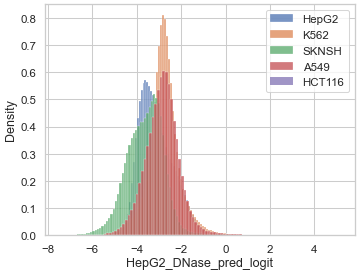

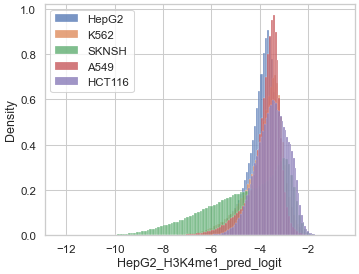

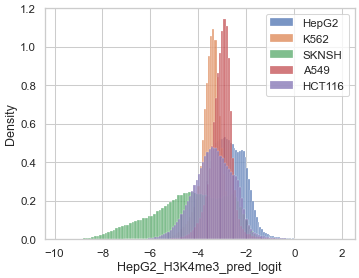

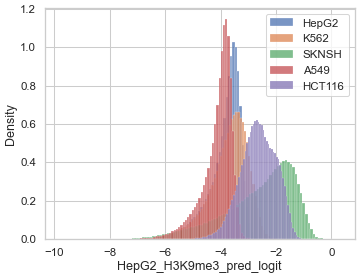

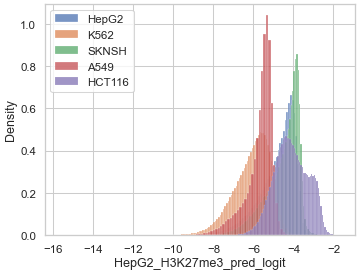

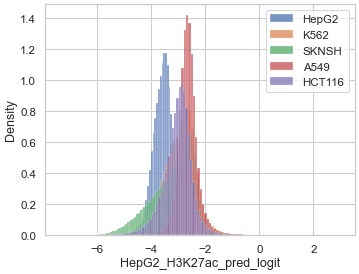

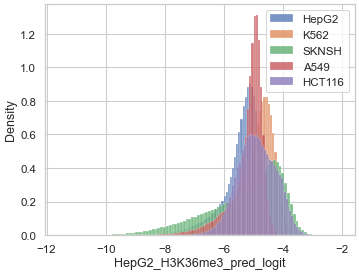

In [17]:
cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
data_splits = ['train', 'valid', 'test']

for assay in assays:
    plt.figure(figsize=(8, 6), dpi=50)
    for cell_type in cell_types:
        for data_split in ['train']:
            selected_index = data_split_index_dict[data_split]
            x = main_df[selected_index][f'{cell_type}_{assay}_pred_logit']
            y = main_df[selected_index][cell_type]
            sns.histplot(x, stat='density', bins=100, label=cell_type)
    plt.legend()

In [18]:
# normalize
for assay in assays:
    for cell_type in cell_types:
        data_split = 'train'
        selected_index = data_split_index_dict[data_split]
        x = main_df[selected_index][f'{cell_type}_{assay}_pred_logit']
        x_mean = np.mean(x)
        x_std = np.std(x)
        main_df[f'{cell_type}_{assay}_pred_logit_norm'] = (main_df[f'{cell_type}_{assay}_pred_logit'] - x_mean) / x_std


for cell_type in cell_types:
    data_split = 'train'
    selected_index = data_split_index_dict[data_split]
    y = main_df[selected_index][f'{cell_type}']
    y_mean = 0
    y_std = np.std(y)
    main_df[f'{cell_type}_norm'] = (main_df[f'{cell_type}'] - y_mean) / y_std

/home/hxcai/anaconda3/envs/torch/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


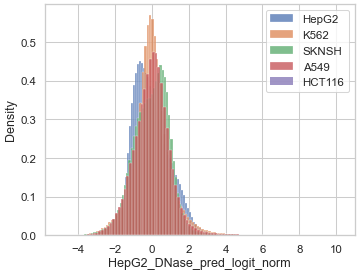

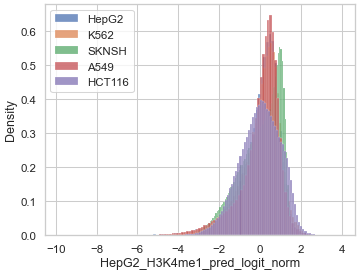

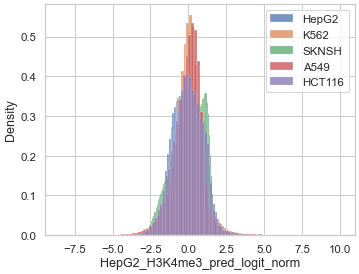

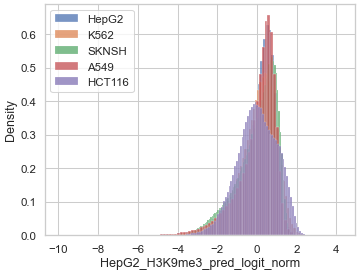

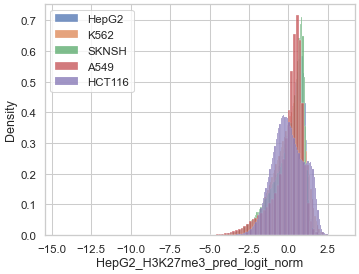

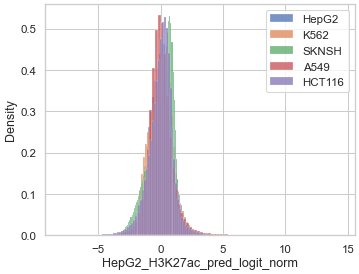

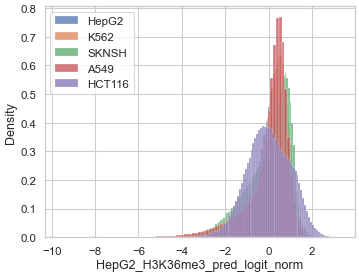

In [19]:
cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
data_splits = ['train', 'valid', 'test']

for assay in assays:
    plt.figure(figsize=(8, 6), dpi=50)
    for cell_type in cell_types:
        for data_split in ['train']:
            selected_index = data_split_index_dict[data_split]
            x = main_df[selected_index][f'{cell_type}_{assay}_pred_logit_norm']
            y = main_df[selected_index][cell_type]
            sns.histplot(x, stat='density', bins=100, label=cell_type)
    plt.legend()

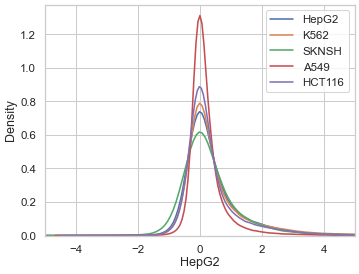

In [20]:
plt.figure(figsize=(8, 6), dpi=50)
for cell_type in cell_types:
    for data_split in ['train']:
        selected_index = data_split_index_dict[data_split]
        x = logit(main_df[selected_index][f'{cell_type}_{assay}_pred'])
        y = main_df[selected_index][cell_type]
        # sns.histplot(y, stat='density', bins=100, label=cell_type, kde=True)
        sns.kdeplot(y, fill=False, label=cell_type)
        plt.xlim([-5, 5])
plt.legend()

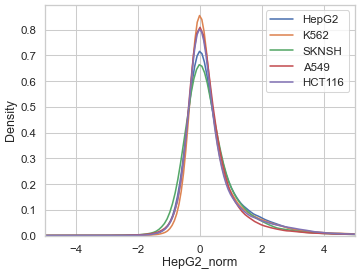

In [21]:
plt.figure(figsize=(8, 6), dpi=50)
for cell_type in cell_types:
    for data_split in ['train']:
        selected_index = data_split_index_dict[data_split]
        y = main_df[selected_index][f'{cell_type}_norm']
        sns.kdeplot(y, fill=False, label=cell_type)
        plt.xlim([-5, 5])
plt.legend()

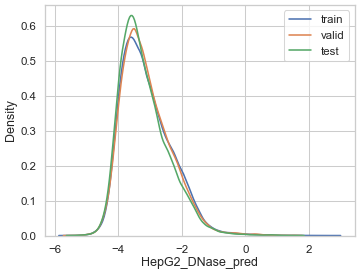

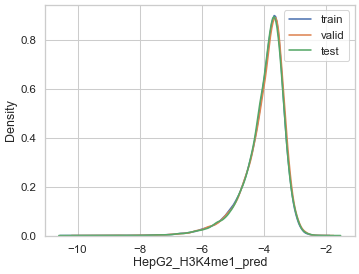

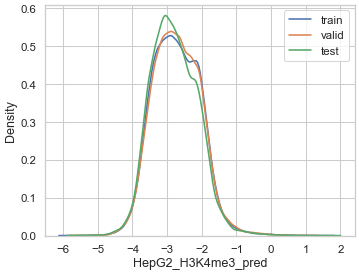

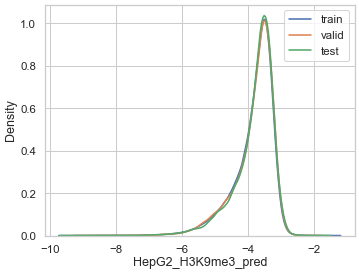

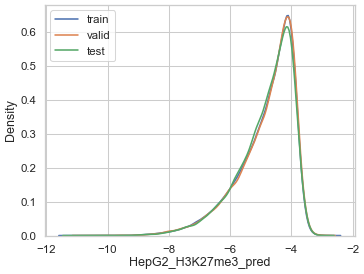

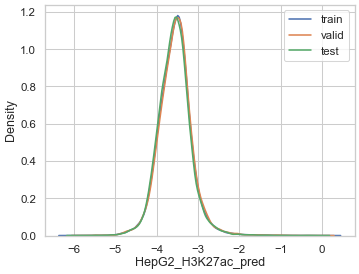

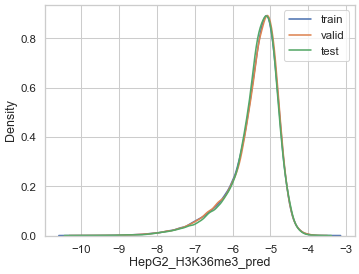

In [22]:
for assay in assays:
    plt.figure(figsize=(8, 6), dpi=50)
    for cell_type in ['HepG2']:
        for data_split in ['train', 'valid', 'test']:
            selected_index = data_split_index_dict[data_split]
            x = logit(main_df[selected_index][f'{cell_type}_{assay}_pred'])
            y = main_df[selected_index][cell_type]
            sns.kdeplot(x, fill=False, label=data_split)
    plt.legend()

In [23]:
cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
data_splits = ['train', 'valid', 'test']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
# assays = ['H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']

for cell_type in cell_types:
    # train
    data_split = 'train'
    print(f'train model by {cell_type} {data_split} data')
    df = main_df[main_df['chr'].isin(data_split_dict[data_split])]
    selected_columns = [f'{cell_type}_{assay}_pred_logit' for assay in assays]
    X_train = np.array(df[selected_columns])
    y_train = np.array(df[cell_type])

    # Remove NaN in X_train or y_train
    mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # model = LinearRegression()
    model = Lasso(alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for cell_type in cell_types:
        for data_split in data_splits:
            df = main_df[main_df['chr'].isin(data_split_dict[data_split])]
            selected_columns = [f'{cell_type}_{assay}_pred_logit' for assay in assays]
            X_valid = np.array(df[selected_columns])
            y_valid = np.array(df[cell_type])

            mask = ~np.isnan(X_valid).any(axis=1) & ~np.isnan(y_valid)
            X_valid = X_valid[mask]
            y_valid = y_valid[mask]
            if len(X_valid) == 0:
                continue
            y_pred = model.predict(X_valid)
            # r = spearman(y_valid, y_pred)
            # print(f"{cell_type} {data_split} Spearman's rho: {r:.3f}")
            r = pearson(y_valid, y_pred)
            print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")
    print()
    print(f'model weights')
    top_coef_index = np.abs(model.coef_).argsort()[::-1][:10]
    for i in top_coef_index:
        print(assays[i], model.coef_[i])
    print('intercept:', model.intercept_)
    print()

train model by HepG2 train data
HepG2 train Pearson's r: 0.503
HepG2 valid Pearson's r: 0.508
HepG2 test Pearson's r: 0.496
K562 train Pearson's r: 0.554
K562 valid Pearson's r: 0.550
K562 test Pearson's r: 0.535
SKNSH train Pearson's r: 0.228
SKNSH valid Pearson's r: 0.230
SKNSH test Pearson's r: 0.202
A549 train Pearson's r: 0.397
A549 valid Pearson's r: 0.434
A549 test Pearson's r: 0.413

model weights
H3K27ac 0.8095873
H3K36me3 0.59640807
H3K27me3 -0.5815585
H3K4me1 -0.5400885
H3K4me3 0.5108887
DNase 0.14795844
H3K9me3 -0.043803606
intercept: 3.2564402

train model by K562 train data
HepG2 train Pearson's r: 0.460
HepG2 valid Pearson's r: 0.457
HepG2 test Pearson's r: 0.444
K562 train Pearson's r: 0.624
K562 valid Pearson's r: 0.615
K562 test Pearson's r: 0.595
SKNSH train Pearson's r: 0.339
SKNSH valid Pearson's r: 0.357
SKNSH test Pearson's r: 0.312
A549 train Pearson's r: 0.470
A549 valid Pearson's r: 0.485
A549 test Pearson's r: 0.455

model weights
H3K4me1 -1.0260826
DNase 1.0

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required by Lasso.

In [ ]:
# using norm

cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
data_splits = ['train', 'valid', 'test']
# assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
assays = ['H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']

for cell_type in cell_types:
    # train
    data_split = 'train'
    print(f'train model by {cell_type} {data_split} data')
    df = main_df[main_df['chr'].isin(data_split_dict[data_split])]
    selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
    X_train = np.array(df[selected_columns])
    y_train = np.array(df[cell_type])

    # Remove NaN in X_train or y_train
    mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # model = LinearRegression()
    model = Lasso(alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for cell_type in cell_types:
        for data_split in data_splits:
            df = main_df[main_df['chr'].isin(data_split_dict[data_split])]
            selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
            X_valid = np.array(df[selected_columns])
            y_valid = np.array(df[cell_type])

            mask = ~np.isnan(X_valid).any(axis=1) & ~np.isnan(y_valid)
            X_valid = X_valid[mask]
            y_valid = y_valid[mask]
            if len(X_valid) == 0:
                continue
            y_pred = model.predict(X_valid)
            r = pearson(y_valid, y_pred)
            print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")
    print()
    print(f'model weights')
    top_coef_index = np.abs(model.coef_).argsort()[::-1][:10]
    for i in top_coef_index:
        print(assays[i], model.coef_[i])
    print('intercept:', model.intercept_)
    print()

train model by HepG2 train data
HepG2 train Pearson's r: 0.496
HepG2 valid Pearson's r: 0.495
HepG2 test Pearson's r: 0.479
K562 train Pearson's r: 0.411
K562 valid Pearson's r: 0.398
K562 test Pearson's r: 0.391
SKNSH train Pearson's r: 0.378
SKNSH valid Pearson's r: 0.367
SKNSH test Pearson's r: 0.352
A549 train Pearson's r: 0.189
A549 valid Pearson's r: 0.177
A549 test Pearson's r: 0.192
HCT116 train Pearson's r: 0.033
HCT116 valid Pearson's r: 0.031
HCT116 test Pearson's r: 0.039

model weights
H3K36me3 0.6779375
H3K27me3 -0.4567169
H3K4me1 -0.38847983
H3K27ac 0.36407188
H3K9me3 -0.2635029
H3K4me3 0.057238378
intercept: 0.41966954

train model by K562 train data
HepG2 train Pearson's r: 0.444
HepG2 valid Pearson's r: 0.444
HepG2 test Pearson's r: 0.426
K562 train Pearson's r: 0.474
K562 valid Pearson's r: 0.461
K562 test Pearson's r: 0.450
SKNSH train Pearson's r: 0.290
SKNSH valid Pearson's r: 0.301
SKNSH test Pearson's r: 0.287
A549 train Pearson's r: 0.285
A549 valid Pearson's r

In [38]:
# # using norm and classify

# auroc = AUROC()
# auprc = AUPRC()

# cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
# data_splits = ['train', 'valid', 'test']
# assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']

# for cell_type in cell_types:
#     # train
#     data_split = 'train'
#     print(f'train model by {cell_type} {data_split} data')
#     df = main_df[main_df['chr'].isin(data_split_dict[data_split])]
#     selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
#     X_train = np.array(df[selected_columns])
#     y_train = np.array(df[cell_type])

#     # Remove NaN in X_train or y_train
#     mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
#     X_train = X_train[mask]
#     y_train = y_train[mask] > 0.5

#     # model = LinearRegression()
#     model = LogisticRegression()
#     model.fit(X_train, y_train)

#     # valid
#     for cell_type in cell_types:
#         for data_split in data_splits:
#             df = main_df[main_df['chr'].isin(data_split_dict[data_split])]
#             selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
#             X_valid = np.array(df[selected_columns])
#             y_valid = np.array(df[cell_type])

#             mask = ~np.isnan(X_valid).any(axis=1) & ~np.isnan(y_valid)
#             X_valid = X_valid[mask]
#             y_valid = y_valid[mask] > 1
#             if len(X_valid) == 0:
#                 continue
#             y_pred = model.predict(X_valid)
            
#             a = auroc(y_pred, y_valid)
#             print(f"{cell_type} {data_split} AUROC: {a:.3f}")
#     print()

In [40]:
# leave-one-out cross-validation

# cell_types = ['HepG2', 'K562', 'SKNSH', 'A549', 'HCT116']
cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
data_splits = ['train', 'valid', 'test'] #'designed'

pd.set_option('display.max_rows', 5)

expanded_df = []
for cell_type in cell_types:
    cell_type_cols = ['seq', 'chr', cell_type] + [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
    cell_type_df = main_df[cell_type_cols]
    cell_type_df.columns = ['seq', 'chr', 'label'] + [assay for assay in assays]
    cell_type_df['cell_type'] = cell_type
    expanded_df.append(cell_type_df)
expanded_df = pd.concat(expanded_df)
expanded_df = expanded_df.dropna()
expanded_df


for cell_type in cell_types:
    # train
    data_split = 'train'
    print(f'train model by not {cell_type} {data_split} data')

    selected_condition = (expanded_df['chr'].isin(data_split_dict[data_split])) & (expanded_df['cell_type'] != cell_type)
    df = expanded_df[selected_condition]
    X_train = np.array(df[assays])
    y_train = np.array(df['label'])

    # Remove rows with NaN values in X_train or y_train
    mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(y_train)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # model = LinearRegression()
    model = Lasso(alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for cell_type in cell_types:
        print(f'valid model')
        for data_split in data_splits:
            selected_condition = (expanded_df['chr'].isin(data_split_dict[data_split])) & (expanded_df['cell_type'] == cell_type)

            df = expanded_df[selected_condition]
            X_valid = np.array(df[assays])
            y_valid = np.array(df['label'])

            mask = ~np.isnan(X_valid).any(axis=1) & ~np.isnan(y_valid)
            X_valid = X_valid[mask]
            y_valid = y_valid[mask]
            if len(X_valid) == 0:
                continue
            y_pred = model.predict(X_valid)
            r = pearson(y_valid, y_pred)
            print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")
    print()
    # print(f'model weights')
    # top_coef_index = np.abs(model.coef_).argsort()[::-1][:10]
    # for i in top_coef_index:
    #     print(assays[i], model.coef_[i])
    # print()

/tmp/ipykernel_750777/1595184070.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_df['cell_type'] = cell_type
/tmp/ipykernel_750777/1595184070.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_df['cell_type'] = cell_type
/tmp/ipykernel_750777/1595184070.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

train model by not HepG2 train data
valid model
HepG2 train Pearson's r: 0.437
HepG2 valid Pearson's r: 0.433
HepG2 test Pearson's r: 0.414
valid model
K562 train Pearson's r: 0.542
K562 valid Pearson's r: 0.527
K562 test Pearson's r: 0.505
valid model
A549 train Pearson's r: 0.441
A549 valid Pearson's r: 0.429
A549 test Pearson's r: 0.409
valid model

train model by not K562 train data
valid model
HepG2 train Pearson's r: 0.495
HepG2 valid Pearson's r: 0.493
HepG2 test Pearson's r: 0.476
valid model
K562 train Pearson's r: 0.434
K562 valid Pearson's r: 0.416
K562 test Pearson's r: 0.403
valid model
A549 train Pearson's r: 0.460
A549 valid Pearson's r: 0.442
A549 test Pearson's r: 0.436
valid model

train model by not A549 train data
valid model
HepG2 train Pearson's r: 0.484
HepG2 valid Pearson's r: 0.482
HepG2 test Pearson's r: 0.465
valid model
K562 train Pearson's r: 0.513
K562 valid Pearson's r: 0.496
K562 test Pearson's r: 0.476
valid model
A549 train Pearson's r: 0.420
A549 vali